## Entire Script

### Package Loading

In [1]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

### Parameters 

In [6]:
import os 

### parameters 

## Generation of ground truth model 

model_name = 'drug_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 1000

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
'''

# Engineering Feature Data 

data_engineering_method = 'last_time_point'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

# Drug parameters 

drugs = [Drug('D0', 500, 500, ['B2'], ['down'])]
dose_response_range = np.linspace(0, 100, 25)

## General parameters
parallelise = True
save_figures = True 
experiment_id = model_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed) + '_' + data_engineering_method
experiment_folder = 'experiments/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

### Core Script

#### Block 1 - Generate Ground Truth Model

In [ ]:
### Generate the ground truth model

model_spec = DrugModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
drug_0.add_regulation('B2', 'down')
model_spec.add_drug(drug_0)

G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)

In [ ]:
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

#### Block 2 - Dose Response Range on Default Model

In [7]:
# iterate through values of `dose_response_range` and simulate the model with the drug
response_data = []
Cp_data = []
model_spec = DrugModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
drug_0.add_regulation('B2', 'down')
model_spec.add_drug(drug_0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
for dose in dose_response_range:
    ### Generate the ground truth model
    model_spec.clear_drugs()
    model_spec.add_drug(drug_0, dose)
    G0_temp = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
    G0_temp = copy_over_params_states(G0, G0_temp)
    runner = roadrunner.RoadRunner(G0_temp.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    # get the last time point of Cp 
    response = res['[Cp]'][-1]
    response_data.append(response)
    Cp_data.append(res['[Cp]'])

### Figure Generation and Visualisation

#### Output 1 - Visualising dose response of target to drug

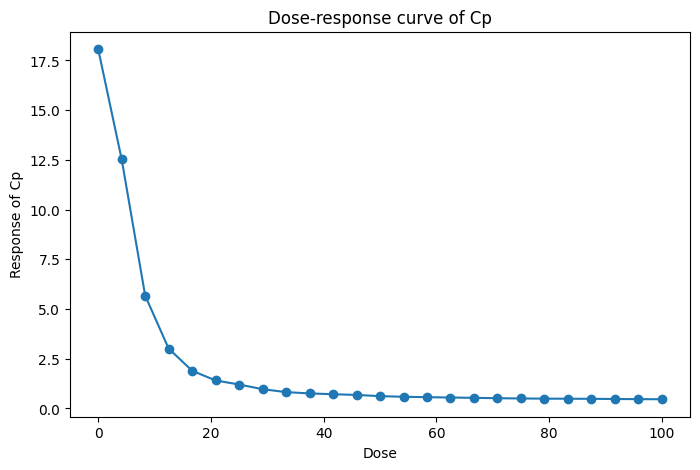

In [8]:
plt.figure(figsize=(8,5))
# plot the dose-response curve 
plt.plot(dose_response_range, response_data, 'o-')
plt.xlabel('Dose')
plt.ylabel('Response of Cp')
plt.title('Dose-response curve of Cp')
plt.show()
# if save_figures:
    # plt.savefig(experiment_folder + 'dose_response_curve.png')


#### Output 2 - Visualise the dynamic of Cp over drug response range

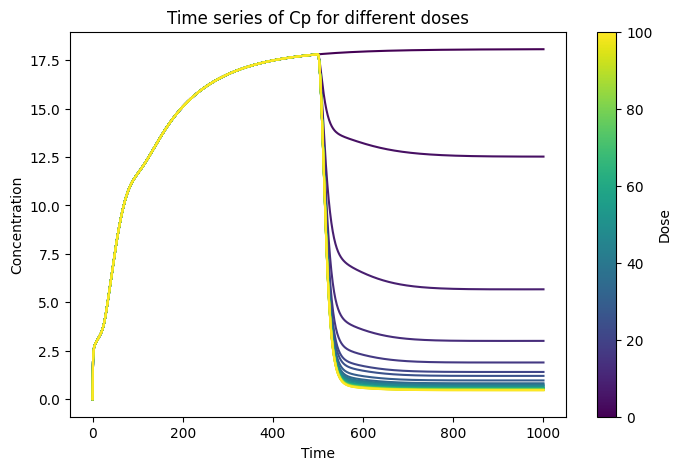

In [17]:
import matplotlib.colors as mcolors
plt.figure(figsize=(8, 5))
# plot the Cp time series for each dose and choose a viridis colormap
norm = mcolors.Normalize(vmin=min(dose_response_range), vmax=max(dose_response_range))  # Ensure the range matches your doses
cmap = plt.cm.viridis
for i, dose in enumerate(dose_response_range):
    plt.plot(res['time'], Cp_data[i], label='Dose: ' + str(dose), color=cmap(norm(dose)))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Time series of Cp for different doses')
# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis')) 
# the colorbar needs to display the dose values 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label('Dose')
plt.show()

#### Cp and C in ground truth model

In [ ]:
# === PLOT: Visible States Over Time ===

# Initialize RoadRunner and simulate the model
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

# Define key observable states
visible_states = ['C', 'Cp']

# Plot the concentration of visible states over time
plt.figure(figsize=(8, 5))
for state in visible_states:
    plt.plot(res['time'], res[f'[{state}]'], label=state)

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration of C and Cp over Time")
plt.grid(True)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_01_C_Cp_time_course_ground_truth.png')
plt.show()

#### All species in ground truth model

In [ ]:
# === PLOT: All Biochemical Species Over Time ===

plt.figure(figsize=(10, 6))

states = model_spec.A_species + model_spec.B_species + model_spec.C_species
# plus the phosphorylated species
states += [s+'p' for s in states]
for state in states:
    plt.plot(res['time'], res[f'[{state}]'], label=state)

plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Temporal Evolution of All Biochemical Species")
plt.grid(True)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_02_all_species_time_course_ground_truth.png')
plt.show()

#### Species versus their phosphorylated forms in Ground Truth Model

In [ ]:
# === MULTI-PLOT: Species vs. Phosphorylated Forms ===
AandB = model_spec.A_species + model_spec.B_species  # Select key species

columns = 4
fig, axs = plt.subplots(len(AandB) // columns + 1, columns, figsize=(4 * columns, 5 * (len(AandB) // columns)))

for i, specie in enumerate(AandB):
    row, col = i // columns, i % columns
    specie_phos = specie + 'p'  # Identify phosphorylated form

    axs[row, col].plot(res['time'], res[f'[{specie}]'], label=specie)
    axs[row, col].plot(res['time'], res[f'[{specie_phos}]'], label=specie_phos)
    axs[row, col].set_title(f'{specie} and {specie_phos}')
    axs[row, col].legend()

plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_03_species_vs_phosphorylated_forms_ground_truth.png')

plt.show()

####  Simulations of the Ground Truth Model based on feature data

In [ ]:
# plot the time course data
time_course_data = np.array(time_course_data)
time_course_data.shape

plt.title('Time course data for all Cp expression following A and B perturbations')
plt.plot(res['time'], time_course_data.T, color='gray', alpha=0.5)
plt.plot(res['time'], time_course_data.mean(axis=0), color='red', label='Mean', alpha=0.8)
plt.plot(res['time'], time_course_data.mean(axis=0) + time_course_data.std(axis=0), color='black', label='Mean + Std', alpha=0.8, linestyle='--')
plt.plot(res['time'], time_course_data.mean(axis=0) - time_course_data.std(axis=0), color='black', label='Mean - Std', alpha=0.8, linestyle='--')
plt.legend()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_04_time_course_feature_data.png')
plt.show()

#### Cp (Target) of the Ground Truth Model versus the Sub-Optimal Model

In [ ]:
# make a sub-plot for the ground truth model and the suboptimal model, showing the Cp expression for C

runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, 500, 100)

runner_sub = roadrunner.RoadRunner(S0.get_sbml_model())
res_sub = runner_sub.simulate(0, 500, 100)

plt.plot(res['time'], res['[Cp]'], label='Ground Truth Cp')
plt.plot(res_sub['time'], res_sub['[Cp]'], label='Suboptimal Cp')
plt.legend()

runner = manual_reset(runner, initial_values)
runner_sub = manual_reset(runner_sub, initial_values)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_05_Cp_expression_comparison.png')
plt.show()

#### Comparison of other species in the Ground Truth Model and the Sub-Optimal Model

In [ ]:
AandB = model_spec.A_species + model_spec.B_species
columns = 4
fig, axs = plt.subplots(len(AandB)//columns+1, columns, figsize=(4*columns, 4*len(AandB)//columns))
for i, specie in enumerate(AandB):
    row = i // columns
    col = i % columns
    # get the phosphorylated specie
    specie_phos = specie + 'p'
    # plot the specie
    # axs[row, col].plot(res_sub['time'], res_sub[f'[{specie}]'], label=specie+'_S0')
    # axs[row, col].plot(res['time'], res_sub[f'[{specie_phos}]'], label=specie+'_G0')
    axs[row, col].plot(res_sub['time'], res_sub[f'[{specie_phos}]'], label=specie_phos+'_S0')
    axs[row, col].plot(res['time'], res[f'[{specie_phos}]'], label=specie_phos+'_G0')
    axs[row, col].set_title(f'{specie} and {specie_phos}')
    axs[row, col].legend()
    
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_06_species_vs_phosphorylated_forms_comparison.png')
plt.show()

#### Scatter plot between feature and target data

In [ ]:
columns = 4
fig, axs = plt.subplots(len(feature_df.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(feature_df.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(feature_df[feature], target_df['Cp'], alpha=0.7, s=10)
    axs[row, col].set_title(f'{feature} vs Cp')
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_07_feature_vs_target.png')
plt.show()

#### Correlation matrix between feature and target data

In [ ]:

feature_target_df = feature_df.copy()
feature_target_df['Cp'] = target_df['Cp']
sns.heatmap(feature_target_df.corr(), annot=True, cmap='viridis', fmt=".2f")

if save_figures:
    plt.savefig(experiment_folder + 'Fig_08_feature_target_correlation.png')
plt.show()

#### Correlation matrix between last time point of ground truth model and target data

In [ ]:
# perform correlation analysis between the last time points and the target data
target_last_time_points_G0 = last_time_points_G0.copy()
target_last_time_points_G0['t'] = target_df['Cp']
sns.heatmap(target_last_time_points_G0.corr(), annot=True, cmap='viridis', fmt=".2f")

if save_figures:
    plt.savefig(experiment_folder + 'Fig_09_G0_phos_last_time_point_target_correlation.png')
plt.show()

#### Scatter plot between last time point of ground truth model and target data

In [ ]:
columns = 4
fig, axs = plt.subplots(len(last_time_points_G0.columns)//columns+1, columns, figsize=(4*columns, 4*len(feature_df.columns)//columns))
for i, feature in enumerate(last_time_points_G0.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(target_df['Cp'], last_time_points_G0[feature], alpha=0.7, s=10)
    axs[row, col].set_title(f'{feature} vs Target')
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_10_G0_phos_last_time_point_vs_target_scatter.png')
plt.show()

#### Correlation matrix between last time point of sub-optimal model and target data

In [ ]:
target_last_time_points_S0 = engineered_feature_df.copy()
target_last_time_points_S0['t'] = target_df['Cp']
sns.heatmap(target_last_time_points_S0.corr(), annot=True, cmap='viridis', fmt=".2f")
if save_figures:
    plt.savefig(experiment_folder + 'Fig_11_S0_phos_last_time_point_target_correlation.png')
plt.show()

#### Scatter plot between last time point of sub-optimal model and target data

In [ ]:
columns = 4
fig, axs = plt.subplots(len(engineered_feature_df.columns)//columns+1, columns, figsize=(4*columns, 4*len(engineered_feature_df.columns)//columns))
for i, feature in enumerate(engineered_feature_df.columns):
    row = i // columns
    col = i % columns
    axs[row, col].scatter(target_df['Cp'], engineered_feature_df[feature], alpha=0.7, s=10)
    axs[row, col].set_title(f'{feature} vs Target')
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Fig_12_S0_phos_last_time_point_vs_target_scatter.png')
plt.show()

#### Pearson Correlation of model prediction versus target data in all models

In [ ]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

#### Mean Squared Error of model prediction versus target data in all models

In [ ]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')

plt.ylim(0,1000)
if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()

### Key data outputs

#### Ground Truth Model Specification

In [ ]:
print(model_spec)

#### Antimony Model of Ground Truth Model

In [ ]:
print(G0.get_antimony_model())

#### Sub-Optimal Model Specification

In [ ]:
print(copy_model_spec)

#### Antimony Model of Sub-Optimal Model

In [ ]:
print(S0.get_antimony_model())  

#### All model performance metrics

In [ ]:
metric_df